Here, we **attempted** to utilize Amazon SageMaker's DeepAR algorithm to predict stock prices based on historical data.

In [4]:
%pip install sagemaker boto3 pandas


Note: you may need to restart the kernel to use updated packages.


In [30]:
import boto3
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sagemaker import get_execution_role, Session
from sagemaker.estimator import Estimator
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
#Used to create bucket from jupyternotebook
# import boto3

# session = boto3.Session(region_name="us-east-1")
# s3 = session.client("s3", endpoint_url="https://s3.us-east-1.amazonaws.com")

# bucket_name = "sagemakerstocks"  # Replace with your bucket name
# file_name = "GOOGL_stock_data.csv"

# # Upload the file
# try:
#     s3.upload_file(file_name, bucket_name, file_name)
#     print(f"File '{file_name}' uploaded successfully to bucket '{bucket_name}'.")
# except Exception as e:
#     print(f"Error: {e}")


[11/28/24 08:30:22] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=642869;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=104022;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

File 'GOOGL_stock_data.csv' uploaded successfully to bucket 'sagemakerstocks'.


In [39]:
import boto3
import sagemaker
import pandas as pd
import json
import matplotlib.pyplot as plt
from sagemaker.estimator import Estimator

# Initialize boto3 session
session = boto3.Session(region_name="us-east-1")
s3 = session.client("s3", endpoint_url="https://s3.us-east-1.amazonaws.com")

bucket_name = "sagemakerstocks"  # Replace with your S3 bucket name
train_file_name = "train.json"  # Training JSON file
output_path = f"s3://{bucket_name}/output/"
session = boto3.Session(region_name=region)
sagemaker_session = Session(boto_session=session)

[11/28/24 18:23:41] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=522679;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=756286;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=363570;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=118078;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

In [33]:
# Load the dataset
data = pd.read_csv("GOOGL_stock_data.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")

# Scale the 'Close' column
scaler = MinMaxScaler()
data["Close_scaled"] = scaler.fit_transform(data[["Close"]])

# Create a train-test split
train_split_date = "2022-01-01"
train_data = data[data["Date"] < train_split_date]
test_data = data[data["Date"] >= train_split_date]

In [34]:
# Convert training data to JSONLines format
deepar_data = [
    {
        "start": train_data["Date"].iloc[0].strftime("%Y-%m-%d"),
        "target": train_data["Close_scaled"].tolist()
    }
]

# Save train data in JSONLines format
with open("train.json", "w") as f:
    for entry in deepar_data:
        f.write(json.dumps(entry) + "\n")

In [35]:
# Upload training data to S3
s3 = boto3.client("s3")
s3.upload_file("train.json", bucket_name, "train.json")
s3_train_path = f"s3://{bucket_name}/train.json"
print(f"Training data uploaded to {s3_train_path}")

Training data uploaded to s3://sagemakerstocks/train.json


In [ ]:
#Used to troubleshoot problems with AWS connection and role problems
# from sagemaker import get_execution_role
# import boto3

# # Initialize a boto3 session with your region
# session = boto3.Session(region_name="us-east-1")

# # Manually specify the role ARN if get_execution_role() doesn't work
# role_arn = "arn:aws:iam::194722424691:user/SageMakerStock"  # Replace with your actual SageMaker role ARN

# # Verify the role ARN
# try:
#     print("Role ARN:", role_arn)
# except Exception as e:
#     print("Error getting role:", e)

Role ARN: arn:aws:iam::194722424691:user/SageMakerStock


In [ ]:
# Role and training path
role = "arn:aws:iam::194722424691:role/SageMaker"  # Replace with your SageMaker role ARN
region = "us-east-1"
s3_train_path = f"s3://{bucket_name}/{train_file_name}"

# Define DeepAR estimator
deepar_estimator = Estimator(
    image_uri=sagemaker.image_uris.retrieve(
        framework="forecasting-deepar", region=region
    ),
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",  
    output_path=f"s3://{bucket_name}/output/",
)

# Set hyperparameters
deepar_estimator.set_hyperparameters(
    time_freq="D",  # Daily
    context_length=30,  # past data to consider
    prediction_length=len(test_data),  # test length for forecast
    epochs=50,
    mini_batch_size=64,
    learning_rate=0.001,
    early_stopping_patience=10,
)

# Training
deepar_estimator.fit({"train": s3_train_path})
print("Training completed.")

[11/28/24 18:39:14] INFO     Same images used for training and inference. Defaulting to image     ]8;id=7102;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=682242;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\image_uris.py#387\387]8;;\
                             scope: inference.                                                                     

                    INFO     Defaulting to the only supported framework/algorithm version: 1.     ]8;id=41530;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=507882;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\image_uris.py#487\487]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=649843;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=72869;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

                    INFO     Creating training-job with name:                                       ]8;id=11756;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=544390;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py#1042\1042]8;;\
                             forecasting-deepar-2024-11-28-17-39-14-477                                            

2024-11-28 17:39:17 Starting - Starting the training job...
2024-11-28 17:39:31 Starting - Preparing the instances for training...
2024-11-28 17:39:56 Downloading - Downloading input data...
2024-11-28 17:40:31 Downloading - Downloading the training image.........
2024-11-28 17:42:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[11/28/2024 17:42:49 INFO 139742547507008] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'e

In [ ]:
# Deployment
predictor = deepar_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large")
print("Model deployed.")


[11/28/24 19:08:53] INFO     Creating model with name: forecasting-deepar-2024-11-28-18-08-53-338   ]8;id=15257;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=927180;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py#4025\4025]8;;\

[11/28/24 19:08:54] INFO     Creating endpoint-config with name                                     ]8;id=645163;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=591248;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py#5820\5820]8;;\
                             forecasting-deepar-2024-11-28-18-08-53-338                                            

                    INFO     Creating endpoint with name forecasting-deepar-2024-11-28-18-08-53-338 ]8;id=822050;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=436063;file://c:\Users\siwma\Desktop\Uni\cloudaislay\MEM\.venv\lib\site-packages\sagemaker\session.py#4642\4642]8;;\

----------!Model deployed.


In [ ]:
import json

from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()  # Ensures the input is sent as JSON
predictor.deserializer = JSONDeserializer()  # Ensures the output is parsed as JSON

# Prepare input for predictions
test_start_date = test_data["Date"].iloc[0].strftime("%Y-%m-%d")
test_target = test_data["Close"].tolist()

prediction_input = {
    "instances": [
        {
            "start": test_start_date,
            "target": test_target,  # Test set values
        }
    ],
    "configuration": {
        "num_samples": 100,
        "output_types": ["quantiles"],
        "quantiles": ["0.1", "0.5", "0.9"],
    },
}

# Serialize input to JSON
prediction_input_json = json.dumps(prediction_input)

predictions = predictor.predict(prediction_input)  # The predictor now handles JSON serialization internally

# Save predictions to JSON
with open("prediction.json", "w") as f:
    json.dump(predictions, f, indent=4)

print("Predictions saved to 'prediction.json'")


Predictions saved to 'prediction.json'


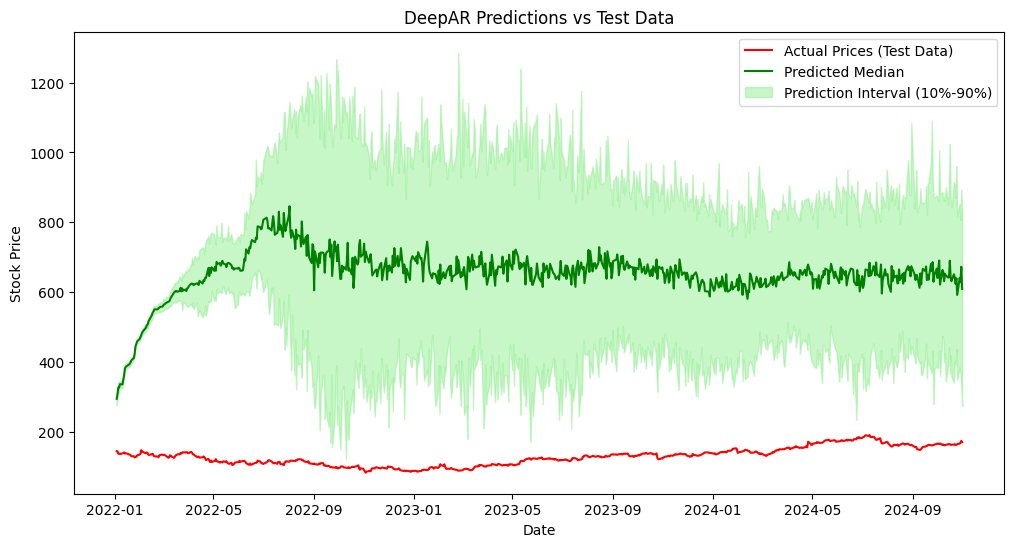

In [50]:
# Load the prediction results
with open("prediction.json", "r") as f:
    predictions = json.load(f)

# Extract quantiles
quantiles = predictions["predictions"][0]["quantiles"]
quantile_10 = quantiles["0.1"]
quantile_50 = quantiles["0.5"]  # Median
quantile_90 = quantiles["0.9"]

# Plot the test data and predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data["Date"], test_data["Close"], label="Actual Prices (Test Data)", color="red")
plt.plot(test_data["Date"], quantile_50, label="Predicted Median", color="green")
plt.fill_between(
    test_data["Date"],
    quantile_10,
    quantile_90,
    color="lightgreen",
    alpha=0.5,
    label="Prediction Interval (10%-90%)"
)

plt.title("DeepAR Predictions vs Test Data")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


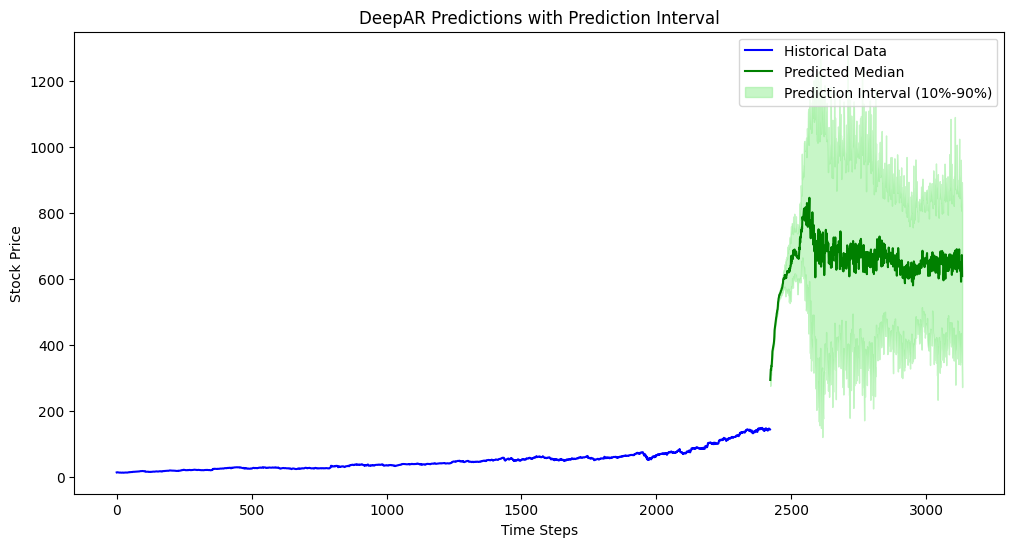

In [51]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load the prediction results (replace 'prediction.json' with your actual file name)
with open('prediction.json', 'r') as f:
    predictions = json.load(f)

# Extract quantiles
quantiles = predictions["predictions"][0]["quantiles"]
quantile_10 = quantiles["0.1"]
quantile_50 = quantiles["0.5"]  # Median
quantile_90 = quantiles["0.9"]

# Assume your original data is in a CSV file and has a column 'Close'
original_data = pd.read_csv('GOOGL_stock_data.csv')
train_data = original_data["Close"][:-len(quantile_50)]  # Exclude the predicted future steps
future_index = range(len(train_data), len(train_data) + len(quantile_50))

# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Historical Data", color="blue")

# Plot predictions with uncertainty
plt.plot(future_index, quantile_50, label="Predicted Median", color="green")
plt.fill_between(future_index, quantile_10, quantile_90, color="lightgreen", alpha=0.5, label="Prediction Interval (10%-90%)")

# Add labels and legend
plt.title("DeepAR Predictions with Prediction Interval")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


Two plots display the output of the DeepAR model, but it is evident that something is fundamentally wrong with the prediction in both cases. The median values are significantly inflated compared to the actual test data. Probably a scaling mismatch or wrong parameterization.
Things that we think were a problem that lead to the outcome: 
- Scaling issues (training vs data probably)
- misconfigured hyperparameters
- DeepAR needs a specific JSONlines formats, but it was done.
The results are not as expected. Model's incorrect predictions serve as a learning point to delve deeper into the nuances of data preparation and parameter truning for time-series forecasting.
